In [1]:
import torch
import nibabel as nib
import niwidgets as nw
import pathlib
from data_utils import MRAData
from blocks import UNet
import numpy as np
import os

import warnings
warnings.filterwarnings(action='ignore')

%load_ext autoreload
%autoreload 2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

unet = UNet(in_channels=1, out_channels=2, final_activation="")
unet.load_state_dict(torch.load("unet28.pth"))
unet.cuda()
print("Loaded model")

Loaded model


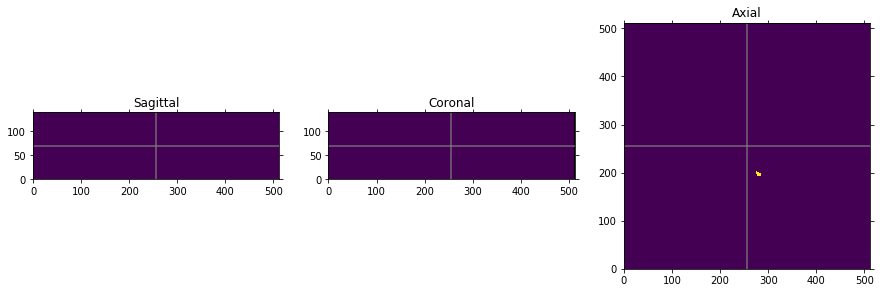

In [3]:
adam_path = pathlib.Path("/home/dhaval/adam_data/")

patient_num = 12

train_data = MRAData(adam_path, patch_size=[124, 124, 60], mode="val")

MRA_path = train_data.cases_dirs[patient_num]
raw_path = str(MRA_path.joinpath("pre/TOF.nii.gz"))
seg_path = str(MRA_path.joinpath("aneurysms.nii.gz"))

# raw_affine = nib.load(raw_path).affine
seg_affine = nib.load(seg_path).affine

location_path = MRA_path.joinpath("location.txt")

# Get center of aneurysm from location.txt file of case
aneurysm_location_coords = train_data.get_aneurysm_coords(location_path)

print("Location: ", aneurysm_location_coords)

raw_widget = nw.NiftiWidget(raw_path)
raw_widget.nifti_plotter()

seg_widget = nw.NiftiWidget(seg_path)
seg_widget.nifti_plotter()

In [4]:
import misc as ms

save_name = MRA_path.joinpath("output.nii.gz")

x = nib.load(raw_path)
x = np.asarray(x.dataobj).astype(np.int32)
x = torch.from_numpy(x).to(dtype=torch.float)
x = x.unsqueeze(0).cuda().detach()

seg_proxy = nib.load(seg_path)
seg_data = np.asarray(seg_proxy.dataobj).astype(np.int32)
target = torch.from_numpy(seg_data).to(dtype=torch.float)

output = ms.test(unet, x, patch_size=68, stride=70)
output = output.detach()

Size:  torch.Size([512, 512, 140])


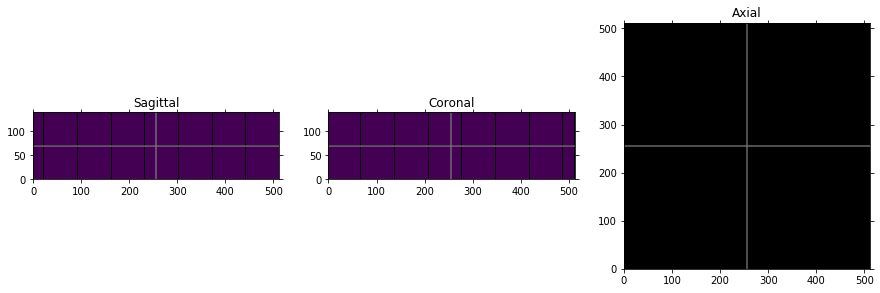

In [5]:
target = target.unsqueeze(0)

print("Check dice")
dice = ms.dice_coeff(output, target)
print("Dice: ", dice.item())

In [ ]:
output = output.detach().cpu().numpy()

out_img = nib.Nifti1Image(output, seg_affine)
nib.save(out_img, str(save_name))

test_widget = nw.NiftiWidget(save_name)
test_widget.nifti_plotter()